### Introduction

##### What is Customer Churn?

Customer churn is defined as when customers or subscribers discontinue doing business with a firm or service.

Customers in the telecom industry can choose from a variety of service providers and actively switch from one to the next. The telecommunications business has an annual churn rate of 15-25 percent in this highly competitive market.

Individualized customer retention is tough because most firms have a large number of customers and can't afford to devote much time to each of them. The costs would be too great, outweighing the additional revenue. However, if a corporation could forecast which customers are likely to leave ahead of time, it could focus customer retention efforts only on these "high risk" clients. The ultimate goal is to expand its coverage area and retrieve more customers loyalty. The core to succeed in this market lies in the customer itself.

Customer churn is a critical metric because it is much less expensive to retain existing customers than it is to acquire new customers.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

To detect early signs of potential churn, one must first develop a holistic view of the customers and their interactions across numerous channels, including store/branch visits, product purchase histories, customer service calls, Web-based transactions, and social media interactions, to mention a few.

As a result, by addressing churn, these businesses may not only preserve their market position, but also grow and thrive. More customers they have in their network, the lower the cost of initiation and the larger the profit. As a result, the company's key focus for success is reducing client attrition and implementing effective retention strategy.

In [ ]:
!pip install imbalanced-learn


In [ ]:
!pip install xgboost


#### Installing depencencies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder ## to convert categorical data into numerical
from imblearn.over_sampling import SMOTE  # Class imbalance handling technique
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import pickle



Data loading & analysis

In [ ]:
df=pd.read_csv(r'C:\Users\user\Documents\Project datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

In [ ]:
## Checking number fo columns & rows
df.shape   

In [ ]:
df.info()

 Dropping customerid column as this is not required for moddeling

In [ ]:
df1=df.drop( columns=['customerID'])

In [ ]:
df1.head(3)

In [ ]:
## Printing unique values in each column
numerical_features=['tenure','TotalCharges','MonthlyCharges']

for col in df1.columns:
    if col not in numerical_features:

        print(col,df1[col].unique())
        print("-"*50)

We expect MonthlyCharges to be numerical but its recorded as object, so we must convert it

In [ ]:
print(df1.isnull().sum())

In [ ]:
## Converting object to float
df1['TotalCharges']=df1['TotalCharges'].astype(float)

This suggets that there are missing values in the column, lets explore this

In [ ]:
df1[df1['TotalCharges']==" "]

In [ ]:
len(df1[df1['TotalCharges']==" "])

There are 11 records where the total monthly charges are blank, this is from the gross adds(New customers) ---> tenure<1


This is probably their first month of doing business with the telco company and thier full month has not been completed, so we are going ro replace these wth zero

In [25]:
## Replacin blanks with 0
df1['TotalCharges']=df1['TotalCharges'].replace({" ":"0.0"})

In [26]:
## Converting object to float
df1['TotalCharges']=df1['TotalCharges'].astype(float)

In [ ]:
df1.info()

In [ ]:
df1.isnull().sum()

Checking the distribution of the target column

In [ ]:
df1['Churn'].value_counts()

Theres a clear imbalance in the dataset with the majority class being not churned


**Insights**

1. Customerid removed as it is not required for modelling
2. No missing values in the dataset
3. Missing values in the 'TotalCharges' column replaced with 0 and converted to float
4. Class imbalamce detected

####  Exploratory Data Analysus--->EDA

In [ ]:
df1.columns

In [ ]:
df1.head(2)

Checking the descriptive stats of the data

In [ ]:
## Remeber this only works on numerical features
df1.describe().T

25% of the data points in montly charges fall under $35 and 50% under $70 .....

In [54]:
## We are going to analyse the numerical features firt

def plot_hist(df,col):
    plt.figure(figsize= (5,3))
    sns.histplot(df[col],kde=True)
    plt.title(f" Distribution of {col}")

    # Calculate the mean and median for the columns
    col_mean=df[col].mean()
    col_media=df[col].median()

    # Add vertical lines for mean and median
    plt.axvline(col_mean,color='red',linestyle=":",label="Mean")
    plt.axvline(col_media,color='green',linestyle="-",label="Median")

    plt.legend()

    plt.show()



In [ ]:
plot_hist(df1,"tenure")

In [ ]:
plot_hist(df1,'MonthlyCharges')

In [ ]:
plot_hist(df1,'TotalCharges')

In [ ]:
## Create a bar plot for 'SeniorCitizen' column
df1['SeniorCitizen'].value_counts().plot.bar(color='skyblue', figsize=(8, 6))

# Add labels and title
plt.title('Bar Plot of SeniorCitizen')
plt.xlabel('SeniorCitizen')
plt.ylabel('Count')

plt.show()


#### Checking for outliers 

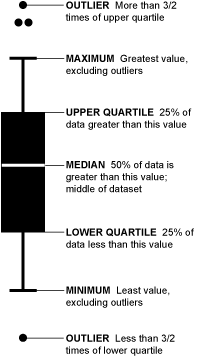                        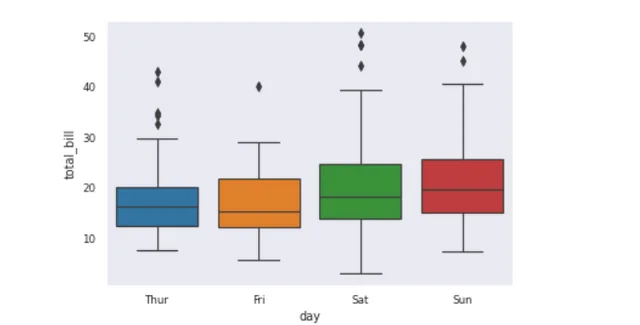




**How to handle outlier:**

1. : Simply remove outlier data points from the dataset. 


2. Winsorization: Replace extreme outlier values with the maximum or minimum value within a specified percentile (e.g., replace values above the 95th 
percentile with the 95th percentile value). 


3. Imputation: Replace outliers with a calculated value like the mean or median of the data. 



In [66]:
# For numerical features

def plot_boxplot(df,col):

    plt.figure(figsize= (5,3))
    sns.boxplot(y=df[col])
    plt.title(f" Box plot of {col}")
    plt.ylabel(col)
    
    plt.show()

In [ ]:
plot_boxplot(df1,'tenure')

In [ ]:
plot_boxplot(df1,'TotalCharges')

In [ ]:
plot_boxplot(df1,'MonthlyCharges')

#### Correlation Heatmap for numerical features

A correlation heatmap helps explain the strength and direction of relationships between multiple variables in a dataset by visually displaying their pairwise correlations using color coding,.

allowing you to quickly identify which variables are strongly positively or negatively correlated and thus guiding feature selection or model building decisions based on these insights; essentially.

it helps you see which variables are related to each other and how strongly, enabling you to focus on the most relevant features in your analysis.

**  What you should do after analyzing a correlation heatmap: *


Identify highly correlated variables:
Look for bright or dark squares that indicate strong positive or negative correlations, respectively.


Address multicollinearity:
If multiple variables are highly correlated with each other, consider removing some of them from your model to avoid issues with multicollinearity, where one variable is essentially redundant with another. 


Feature selection:
Prioritize variables that have strong correlations with your target variable for further analysis and model building. 


Investigate unexpected relationships:
Explore further any surprising or counterintuitive correlations that emerge from the heatmap. 
Consider dimensionality reduction techniques:
If you have a very large dataset with many highly correlated variables, consider techniques like Principal Component Analysis (PCA) to reduce dimensionality. 




In [ ]:
## Correlation matrix heatmap

plt.figure(figsize=(8,4))
sns.heatmap(df1[numerical_features].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title(" Correlation heatmap")
plt.show()


#### Categorical feature Analysis

We usually use count plots to how the categorical features are distributed

In [ ]:
categorical_features=[col for col  in df1.columns if  col not in numerical_features ]

## Alternative method
cat_features=df1.select_dtypes(include="object").columns.to_list()
cat_features

## To add seniro citizen
cat_features=['SeniorCitizen']+cat_features
cat_features

In [ ]:
## This makes inclusing of senior citizen

categorical_features


In [ ]:
for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x=df1[col])
    plt.title(f"Count Plot of {col}")
    plt.show()

#### Data Pre-processing

In [ ]:
# Label enncoding categorical Features

df1.head(3)

In [ ]:
## Label encoding of target column

df1['Churn'].replace({
            "No":0 ,
            "Yes":1 
            
}, inplace=True)

In [ ]:
df1.head(3)

In [ ]:
## Label encoding of other categorical features (Object data types)

categorical_features1=df1.select_dtypes(include="object").columns.to_list()
categorical_features1


In [89]:
# Initialise a dictionary for the encoder
encoders={}

# Apply label encoding and save the encoders
for col in categorical_features1:
    label_encoder=LabelEncoder()
    df1[col]=label_encoder.fit_transform(df1[col])
    encoders[col]=label_encoder

    # save the encoders to a pikle file
    with open("encoders.pkl","wb") as f:
        pickle.dump(encoders,f)

In [ ]:
encoders

In [ ]:
df1

#### Handling class imbalance

Via SMOTE way


Training & Test data split

In [ ]:
x=df1.drop(columns='Churn',axis=1)
y=df1.Churn

In [ ]:
## Split trining and test data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)


Synthetic Minority Over-sampling Technique


What is SMOTE? SMOTE stands for Synthetic Minority Over-sampling Technique. It is an oversampling technique used to balance the class distribution of a dataset by creating synthetic minority class samples.

** This is only done on the training data**

In [97]:
smote=SMOTE(random_state=42)

In [98]:
x_train_smote,y_train_smote=smote.fit_resample(x_train,y_train)

In [ ]:
y_train_smote.value_counts()

#### Model Training


**Notes:**


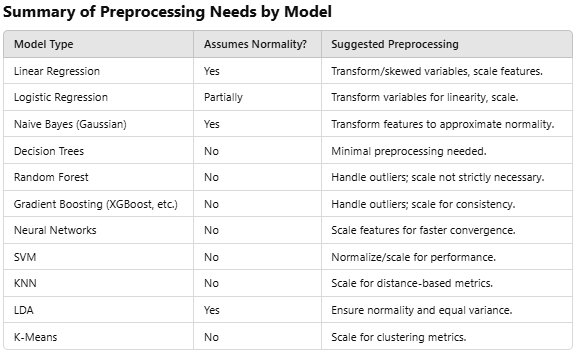


Key Notes:


Scaling: Models like SVM, KNN, and neural networks benefit from scaling, even if they don’t need normality.

Transformation: For models expecting normality, consider log, square root, or Box-Cox transformations for skewed data.

Outliers: Non-tree models are generally more sensitive to outliers.


These features are not normally distributed so we need to scale or normalise  them for logistic regression, SVM etc but for tree base models we don't need to do thus becuase they are not sensitive to outliers

In [100]:
## First train the models with default parameters and thne use hyper-parameter training

# Dctionary of models

models={
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest":RandomForestClassifier(random_state=42),
    "XGBoost":XGBRFClassifier(random_state=42)
}



#### Cross Validation

Cross-validation is a statistical technique used in machine learning to evaluate a model's performance by repeatedly dividing the dataset into different subsets, training the model on some subsets, and testing it on the remaining subsets.

which helps assess how well the model generalizes to unseen data and prevents overfitting, with its scores providing an estimate of how well the model will perform on new, unknown data points;
 
essentially, it helps you choose the best model for your task by providing a more reliable measure of its predictive accuracy across different data samples. 

In [ ]:
# Cross Validation, Dictionary to store cross validation results

cv_scores={}

# Perfom 5 fold cross validation for all these models
for model_name,model in models.items():
    print(f"Training of {model_name} with default hyperparameters")
    scores=cross_val_score(model,x_train_smote,y_train_smote,cv=5,scoring='accuracy')
    cv_scores[model_name]=scores
    print(f"{model_name}  Cross validation accuracy: {np.mean(scores):.2f}")
    print("-"*70)


In [ ]:
cv_scores

Random forest gives the highest accuracy over all the other models

In [106]:
rcf=RandomForestClassifier(random_state=42)

In [ ]:
rcf.fit(x_train_smote,y_train_smote)

#### Model Evaluation

In [ ]:
y_test_pred=rcf.predict(x_test)

print("Accuracy score \n:",accuracy_score(y_test,y_test_pred))
print("Confusing Matrix \n:",confusion_matrix(y_test,y_test_pred))
print("Classification Report \n:",classification_report(y_test,y_test_pred))

In [109]:
## Saved the trained model as a pickle file

with open("customer_churn_model.plk","wb") as f:

    pickle.dump(rcf,f)
    

    

** Load the saved model and build a predictive system **

